In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, mean_absolute_error
%matplotlib inline 

In [3]:
# color dict (use: colors['XColor'])
import ast
with open('color_palette.txt', 'r') as file:
    contents = file.read()
    colors = ast.literal_eval(contents)

In [4]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
results_dir = rdrive + 'processed_results/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [5]:
# uncertainty for both MLL and Scikit are now sqrt(counts), but implemented differently (std dev versus rand err method in scikit)
# nuc and act trainsets use flat 5% unc/rand err
# 6.7% of the train set is reserved as test set (randomly in each case, but also implemented differently)

In [6]:
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_mimic_mll.csv'

# Box Plots

In [7]:
algcol = ['knn', 'dtree', 'mll']

In [8]:
x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
def box_plot(pred_param, title):
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,8))
    axs[1].set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        axs[0].set_ylabel('B. Accuracy Score', fontsize=20, labelpad=15)
    else:
        err = 'Mean Abs Error'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        axs[0].set_ylabel(yaxlbl, fontsize=20, labelpad=15)
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=.85)
    for i, ax in enumerate(axs):
        #sns.boxplot(df.loc[:, algcol[i]], orient='v', ax=ax)
        sns.catplot(data=df.loc[:, algcol[i]], ax=ax, kind='box')
        ax.set_title(algcol[i], fontsize=20)
        ax.set_xticklabels(x)
        ax.tick_params(labelsize=12, labelrotation=45)
        ax.set_ylim(0,3000)
    plt.show()
    return

<Figure size 432x288 with 0 Axes>

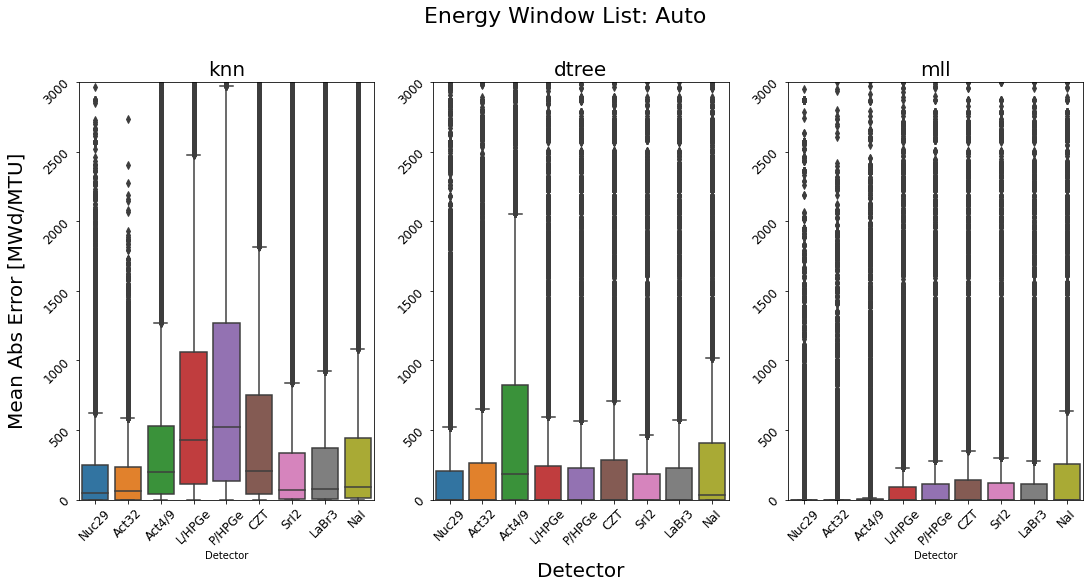

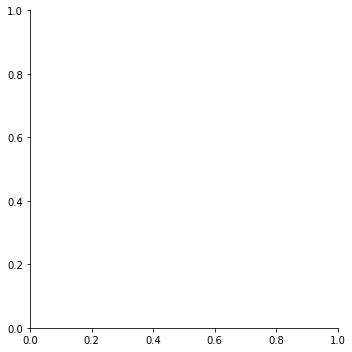

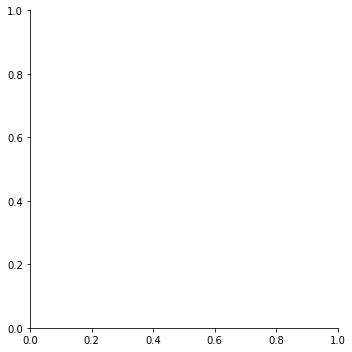

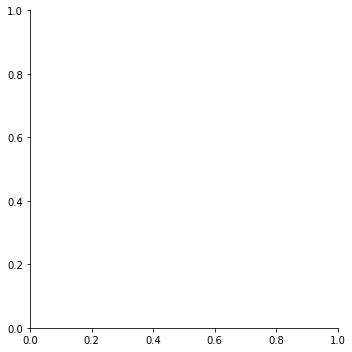

In [86]:
df = pd.read_pickle(results_dir + 'burnup_auto_abserr_mll_scikit_compare.pkl')
box_plot('burnup', 'Energy Window List: Auto')

<Figure size 432x288 with 0 Axes>

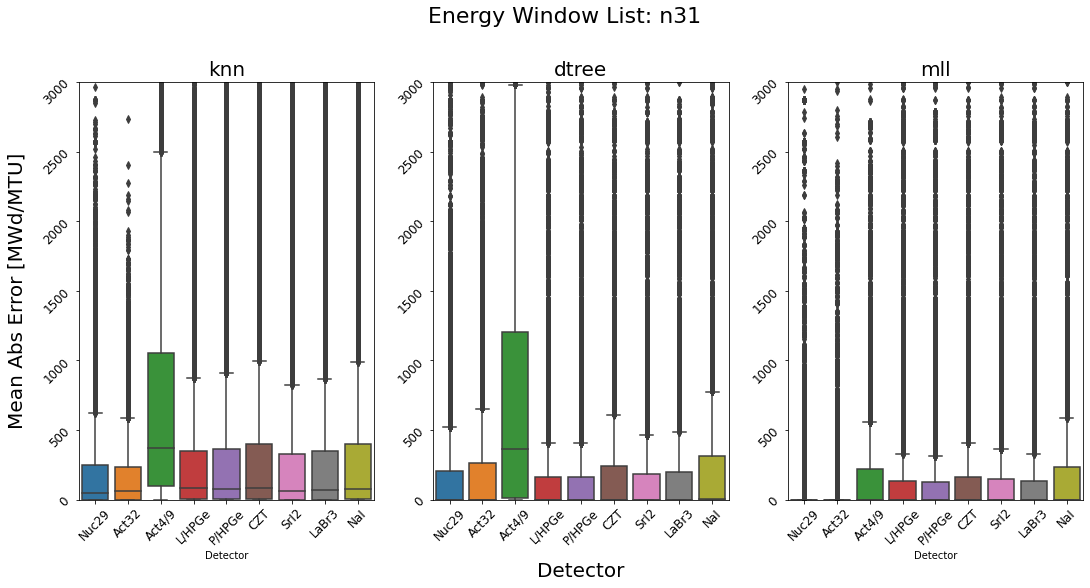

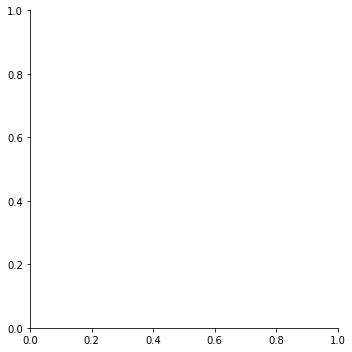

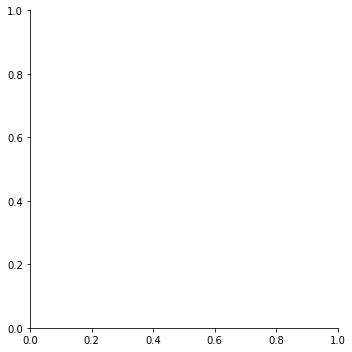

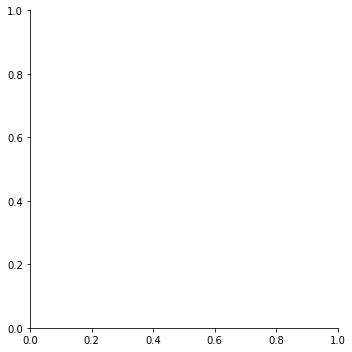

In [87]:
df = pd.read_pickle(results_dir + 'burnup_n31_abserr_mll_scikit_compare.pkl')
box_plot('burnup', 'Energy Window List: n31')

# Error Bar Plots

In [9]:
with open(rdrive + 'processed_results/metrics_results_dict_mll_scikit_compare.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [10]:
x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
_x = np.arange(len(x))
d_x = [-0.2, 0, 0.2]
ens = ['_auto', '31', '113']
en_lbl = ['Auto', '31', '113']
algs = ['dtree', 'knn', 'mll']
alg_lbl = ['Dec Tree', 'kNN', 'MLL Calc']
c_ens = ['M', 'M', 'M']
c_algs = ['L', 'M', 'D']
c = ['Teal', 'Brwn', 'Purp']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']

In [50]:
def plot_by_enlist(a, ax, fig, plotdf, metric, std):
    ax.set_title(en_lbl[a]+' Energy Windows', fontsize=16)
    for i in range(0,3):
        y = np.array(plotdf[algs[i]+ens[a]][metric], dtype=float)
        sd = np.array(plotdf[algs[i]+ens[a]][std], dtype=float)
        _, _, bars = ax.errorbar(_x+d_x[i], y, yerr=sd, color=colors[c_ens[i]+c[i]], marker='o', linestyle='None', mew=0, ms=7, elinewidth=3, label=alg_lbl[i])
        plt.xticks(_x, x)
        [bar.set_alpha(0.4) for bar in bars]
        #ax.plot(x, y, 'o-', color=colors[c_ens[i]+c[i]], mew=0, ms=5, label=alg_lbl[i])
        #ax.fill_between(x, y - sd, y + sd, color=colors[c_ens[i]+c[i]], alpha=0.35)
    ax.legend(loc='lower center', title='Algorithm', ncol=3)
    return fig

def plot_by_alg(a, ax, fig, plotdf, metric, std):
    ax.set_title(alg_lbl[a], fontsize=16)
    for i in range(0,3):
        y = np.array(plotdf[algs[a]+ens[i]][metric], dtype=float)
        sd = np.array(plotdf[algs[a]+ens[i]][std], dtype=float)
        _, _, bars = ax.errorbar(_x+d_x[i], y, yerr=sd, color=colors[c_algs[i]+c[a]], marker='o', linestyle='None', mew=0, ms=7, elinewidth=3, label=en_lbl[i])
        [bar.set_alpha(0.4) for bar in bars]
        plt.xticks(_x, x)
        #ax.plot(x, y, 'o-', color=colors[c_algs[i]+c[a]], mew=0, ms=5, label=en_lbl[i])
        #ax.fill_between(x, y - sd, y + sd, color=colors[c_algs[i]+c[a]], alpha=0.35)
    ax.legend(loc='lower center', title='Energy Windows', ncol=3)
    return fig

In [53]:
def plot(pred_param, title, plttype, pred_min):
    plt.clf()
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,6))
    axs[1].set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        axs[0].set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        axs[0].set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    plotdf = results[pred_param]
    for a, ax in enumerate(axs):
        if plttype == 'enlist':
            plot_by_enlist(a, ax, fig, plotdf, metric, std)
        else:
            plot_by_alg(a, ax, fig, plotdf, metric, std)
        ax.tick_params(labelsize=12, labelrotation=45)
        if pred_param == 'reactor': 
            ax.set_ylim(None, 1.15)
        elif pred_param == 'burnup':
            ax.set_ylim(None, 480)
        elif pred_param == 'cooling':
            ax.set_ylim(-380, 49)
        else:
            ax.set_ylim(None, 0.249)
        hcolor = ['tab:red', 'tab:blue']
        for w, pmin in enumerate(pred_min):
            ax.axhline(y=pmin, color=hcolor[w], linestyle='-', linewidth=2)
    
    fig.suptitle(title, fontsize=22)
    fig.subplots_adjust(top=.85)
    plt.show()
    
    sv_fig = './plots/detector_preds_wrt_' + plttype + '_' + pred_param + '.png'
    fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

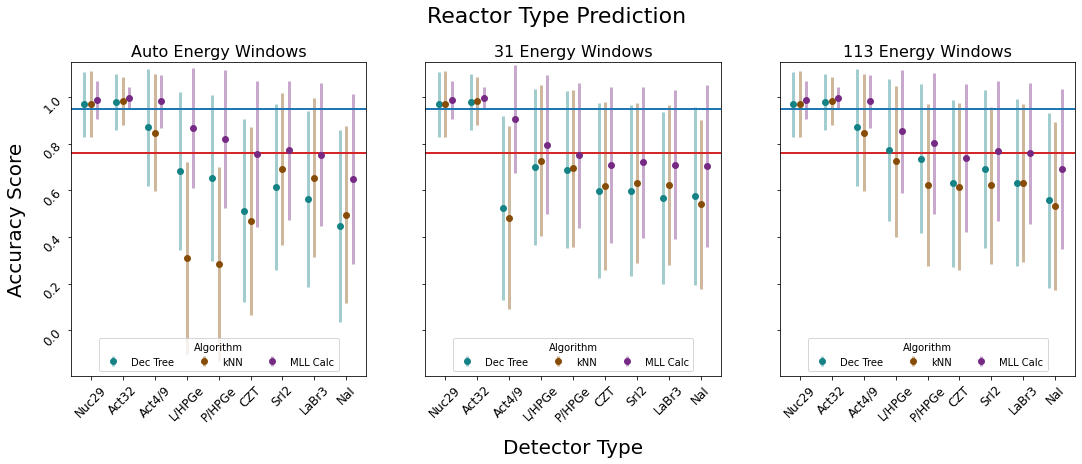

<Figure size 432x288 with 0 Axes>

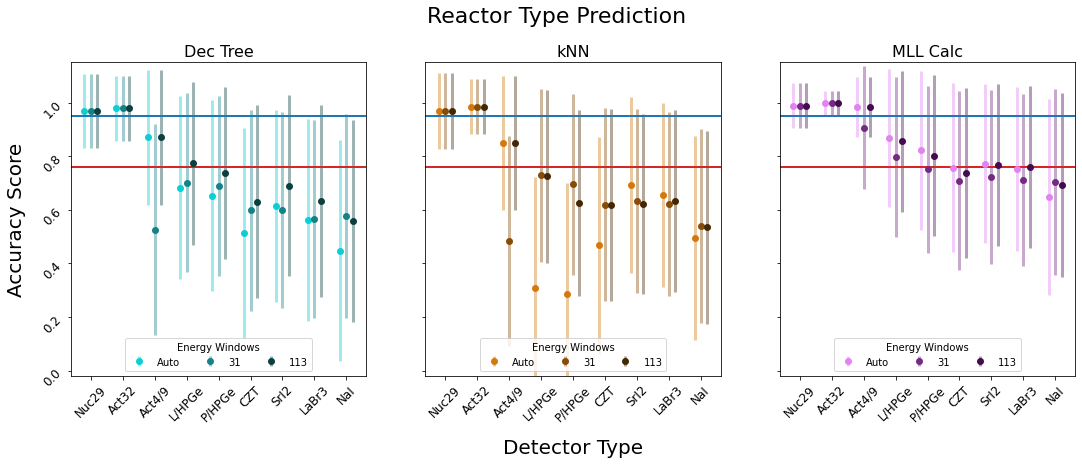

In [54]:
rxtr_min = [0.76, 0.95]
plot('reactor', 'Reactor Type Prediction', 'enlist', rxtr_min)
plot('reactor', 'Reactor Type Prediction', 'alg', rxtr_min)
# balanced accuracy score now used

<Figure size 432x288 with 0 Axes>

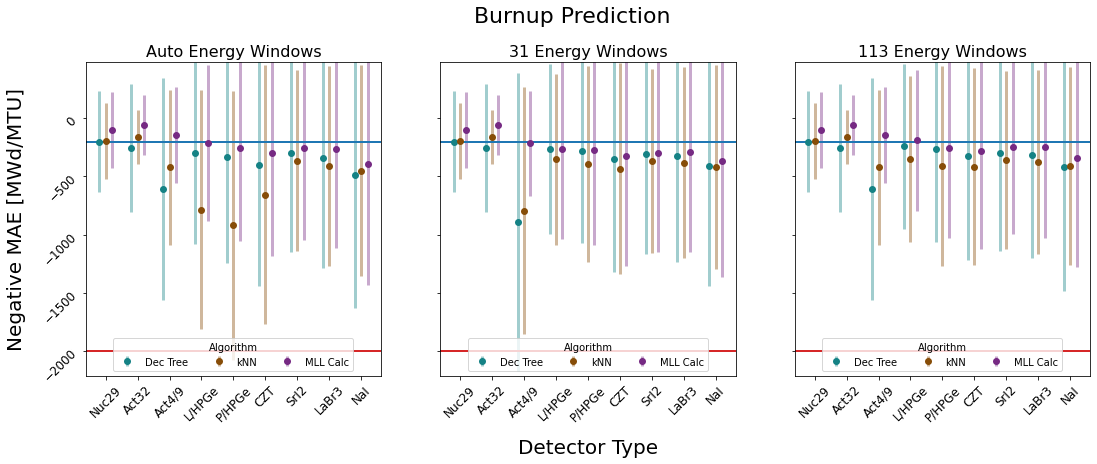

<Figure size 432x288 with 0 Axes>

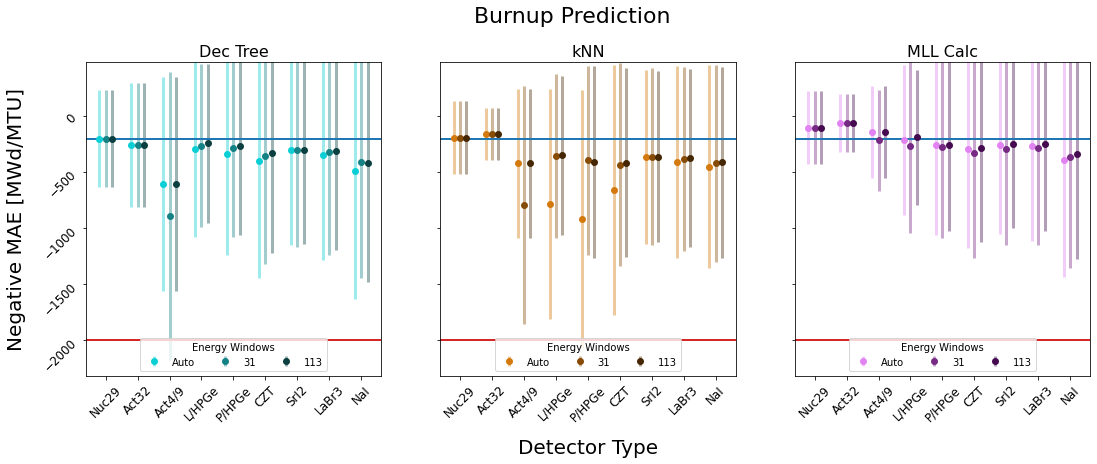

In [55]:
burn_min = [-2000, -200]
plot('burnup', 'Burnup Prediction', 'enlist', burn_min)
plot('burnup', 'Burnup Prediction', 'alg', burn_min)

<Figure size 432x288 with 0 Axes>

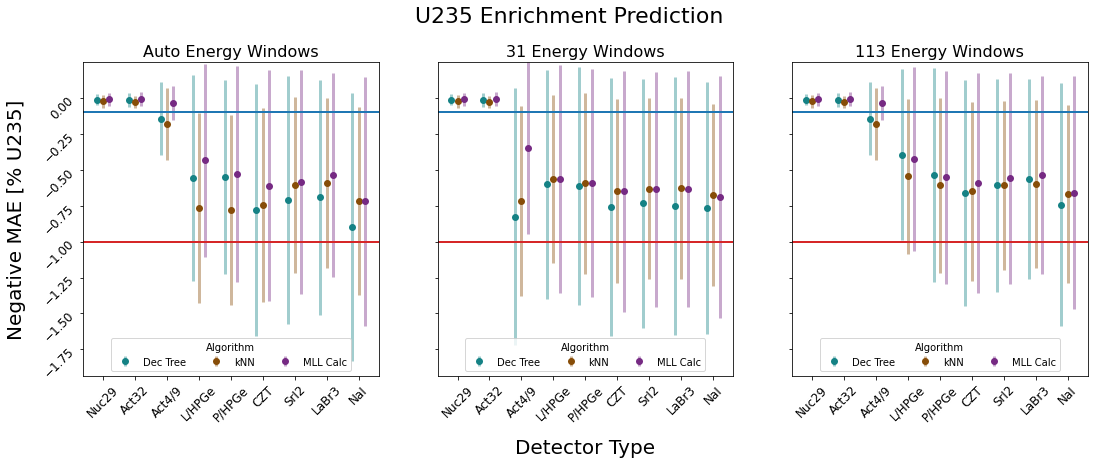

<Figure size 432x288 with 0 Axes>

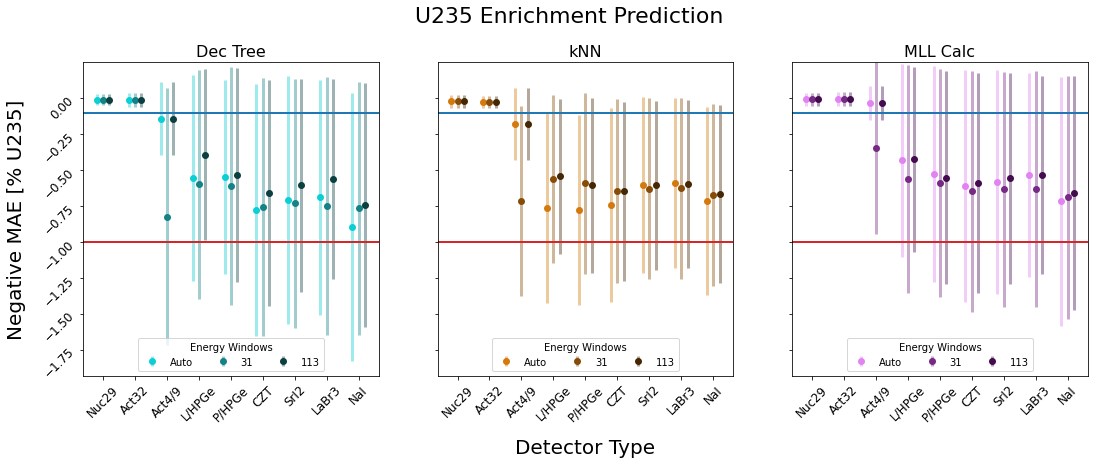

In [56]:
enri_min = [-1.0, -0.1]
plot('enrichment', 'U235 Enrichment Prediction', 'enlist', enri_min)
plot('enrichment', 'U235 Enrichment Prediction', 'alg', enri_min)

<Figure size 432x288 with 0 Axes>

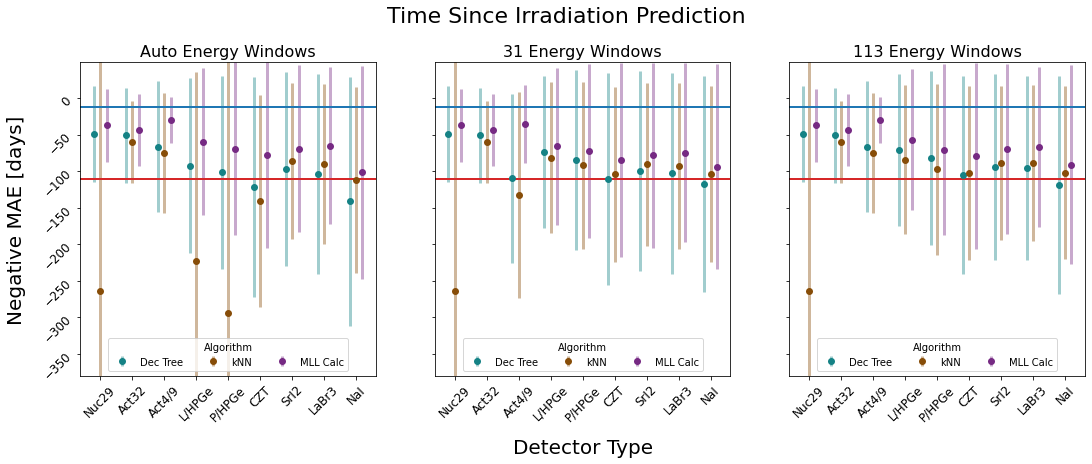

<Figure size 432x288 with 0 Axes>

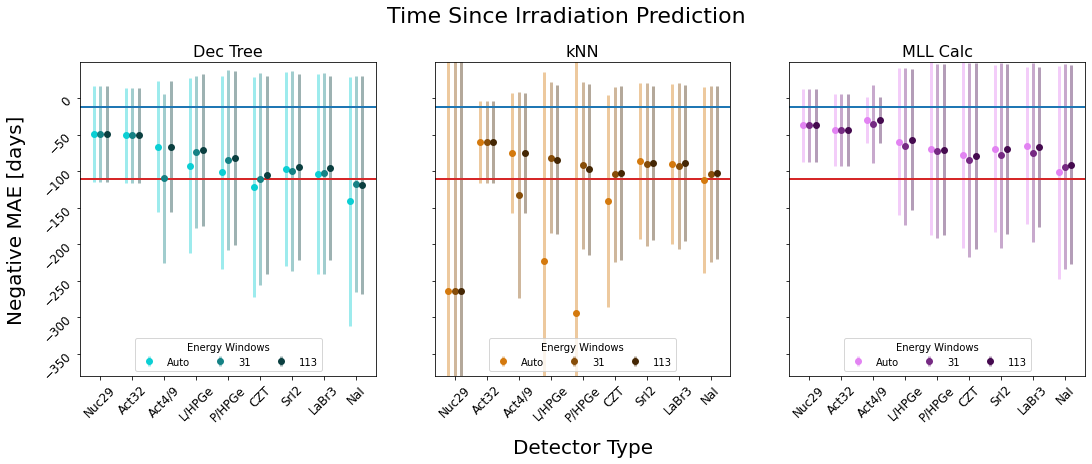

In [57]:
cool_min = [-111, -12]
plot('cooling', 'Time Since Irradiation Prediction', 'enlist', cool_min)
plot('cooling', 'Time Since Irradiation Prediction', 'alg', cool_min)